LOAD RELEVANT LIBRARIES

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import single, average, complete, fcluster, linkage
import re
from sklearn.metrics import adjusted_rand_score, jaccard_score
from sklearn.cluster import AgglomerativeClustering
from itertools import combinations
from collections import defaultdict

INPUT SPECIES NAME (FOR LABELING)

In [2]:
species = 'B_longum'

READ IN DATA

In [3]:
# make it possible for user to select which tools they are inputting??

skani_file_path = f'/Users/Annaliese/Desktop/PopGenStats_Project/data/{species}/distances/skani.tsv.gz'

In [4]:
skani_matrix = pd.read_csv(skani_file_path, sep='\t')
skani_matrix['Tool'] = 'skANI'

TIDY TOOL MATRIX
- SHORTEN SAMPLE FILE NAMES
- ASSIGN SAMPLES A SIMPLIFIED SAMPLE ID
- CALCULATE ANI FOR ALIGNED BASES

In [5]:
def edit_accession_id(str):
    match = re.search(r'(GCF_|GCA_)\d{9}\.\d|flye.SQK-NBD\d{3}-\d{2}_barcode\d{2}', str)
    if match:
        return match.group(0)
    return None

In [6]:
skani_matrix['aligned_bases1'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_ref'] / 100)
skani_matrix['aligned_bases2'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_query'] / 100)

skani_matrix['Ref_file'] = skani_matrix['Ref_file'].apply(edit_accession_id)
skani_matrix['Query_file'] = skani_matrix['Query_file'].apply(edit_accession_id)

skani_sample_names = sorted(set(skani_matrix['Ref_file']) | set(skani_matrix['Query_file']))
skani_mapper = {name: f'sample{idx}' for idx, name in enumerate(skani_sample_names)}

skani_matrix['ref'] = skani_matrix['Ref_file'].map(skani_mapper)
skani_matrix['query'] = skani_matrix['Query_file'].map(skani_mapper)

skani_matrix

,Ref_file,Query_file,ANI,Align_fraction_ref,Align_fraction_query,Ref_name,Query_name,Tool,aligned_bases1,aligned_bases2,ref,query
0,flye.SQK-NBD114-96_barcode49,GCF_002833175.1,98.73,83.96,78.95,contig_1 rotated=True rotated_gene=dnaA,NZ_PJED01000001.1 Bifidobacterium longum strai...,skANI,82.893708,77.947335,sample567,sample142
1,flye.SQK-NBD114-96_barcode49,GCF_004334855.1,98.43,83.84,78.57,contig_1 rotated=True rotated_gene=dnaA,NZ_SHTT01000001.1 Bifidobacterium longum subsp...,skANI,82.523712,77.336451,sample567,sample331
2,flye.SQK-NBD114-96_barcode49,GCF_026520385.1,98.74,82.42,79.50,contig_1 rotated=True rotated_gene=dnaA,NZ_WMFR01000010.1 Bifidobacterium longum subsp...,skANI,81.381508,78.498300,sample567,sample520
3,flye.SQK-NBD114-96_barcode49,GCA_958435375.1,98.60,82.91,81.25,contig_1 rotated=True rotated_gene=dnaA,CAUBFY010000001.1 MAG TPA_asm: Bifidobacterium...,skANI,81.749260,80.112500,sample567,sample63
4,flye.SQK-NBD114-96_barcode49,GCF_004333265.1,98.84,84.66,81.85,contig_1 rotated=True rotated_gene=dnaA,NZ_SHRW01000001.1 Bifidobacterium longum subsp...,skANI,83.677944,80.900540,sample567,sample252
...,...,...,...,...,...,...,...,...,...,...,...,...
188186,GCF_016759765.1,GCF_020531735.1,98.74,86.11,84.17,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_JAJBBY010000010.1 Bifidobacterium longum su...,skANI,85.025014,83.109458,sample410,sample489
188187,GCF_016759765.1,GCF_017312565.1,98.90,84.12,85.80,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_BNGZ01000001.1 Bifidobacterium longum subsp...,skANI,83.194680,84.856200,sample410,sample422
188188,GCF_016759765.1,GCF_030414115.1,98.50,84.51,79.61,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_QCZN01000001.1 Bifidobacterium longum subsp...,skANI,83.242350,78.415850,sample410,sample544
188189,GCF_016759765.1,GCF_019131725.1,98.89,87.36,85.83,NZ_JAERWG010000001.1 Bifidobacterium longum su...,NZ_JAHOMU010000010.1 Bifidobacterium longum st...,skANI,86.390304,84.877287,sample410,sample477


CHECK THAT SAMPLES MEET SPECIES-LEVEL CUTOFF

In [7]:
if (skani_matrix['ANI'].min() < 95).any().any():
    raise ValueError("Samples do not meet species-level ANI cutoff (95%)")

CHECK HOW MANY SAMPLES BELONG TO OUR LAB

In [8]:
unique_barcodes = skani_matrix['Ref_file'].str.contains(r'flye.SQK-NBD114-96_barcode\d{2}', regex=True)
unique_names = skani_matrix[unique_barcodes]['Ref_file'].unique()
len(unique_names)

47

MAKE ANI MATRIX
- PLOT SAMPLES AGAINST EACH OTHER
- MANUALLY ADD DIAGONAL DATA (SAMPLES PLOTTED AGAINST THEMSELVES - 100% SIMILARITY)

In [9]:
skani_diagonal_data = []
for sample in skani_sample_names:
    skani_diagonal_data.append({
        'Ref_file': sample,
        'Query_file': sample,
        'ANI': 100,
        'Align_fraction_ref': 100,
        'Align_fraction_query': 100,
        'Ref_name': '',
        'Query_name': '',
        'ref': skani_mapper[sample],
        'query': skani_mapper[sample],
        'aligned_bases1': 100,
        'aligned_bases2': 100,
        'Tool': 'skANI'
    })

skani_diagonal_df = pd.DataFrame(skani_diagonal_data)
skani_matrix = pd.concat([skani_matrix, skani_diagonal_df], ignore_index=True)

skani_matrix = skani_matrix.sort_values(by=['Ref_file', 'Query_file']).reset_index(drop=True)

skani_upper_triangle = skani_matrix.pivot(index='ref', columns='query', values='ANI').fillna(0)
skani_upper_triangle = skani_upper_triangle[sorted(skani_upper_triangle.columns)]

skani_lower_triangle = skani_matrix.pivot(index='query', columns='ref', values='ANI').fillna(0)
skani_lower_triangle = skani_lower_triangle[sorted(skani_lower_triangle.columns)]

new_skani_matrix = skani_upper_triangle + skani_lower_triangle
new_skani_matrix[:] = np.where(new_skani_matrix==200, 100, new_skani_matrix)

new_skani_matrix

query,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.00,99.76,98.30,96.82,98.89,98.65,98.77,98.91,98.56,98.89,...,98.72,98.87,98.70,98.70,98.76,98.83,98.87,96.81,98.72,96.57
sample1,99.76,100.00,98.85,96.85,98.98,98.57,98.76,98.88,98.76,98.98,...,98.93,98.99,98.80,98.88,98.87,98.98,98.94,97.10,98.93,96.74
sample10,98.30,98.85,100.00,96.12,98.56,98.48,98.71,98.65,98.51,98.35,...,98.49,98.72,98.59,98.57,98.46,98.56,98.26,96.82,98.46,96.37
sample100,96.82,96.85,96.12,100.00,96.51,96.40,96.24,96.48,96.55,96.82,...,96.51,96.41,96.42,96.54,96.61,96.58,96.41,98.18,96.24,99.99
sample101,98.89,98.98,98.56,96.51,100.00,98.74,98.90,99.04,98.82,99.01,...,99.03,99.08,98.70,99.08,98.86,99.03,98.86,96.92,98.92,96.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,98.83,98.98,98.56,96.58,99.03,98.57,99.08,98.88,98.90,98.95,...,98.97,99.08,98.90,99.09,98.97,100.00,99.02,97.01,98.97,96.55
sample96,98.87,98.94,98.26,96.41,98.86,98.47,98.48,98.94,98.72,98.97,...,98.86,98.82,98.58,98.71,98.63,99.02,100.00,96.92,98.48,96.55
sample97,96.81,97.10,96.82,98.18,96.92,96.75,97.01,96.98,96.94,97.07,...,97.01,97.15,96.72,97.01,97.01,97.01,96.92,100.00,96.64,98.10


VISUALIZE ANI DISTRIBUTION

In [10]:
new_skani_matrix

query,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.00,99.76,98.30,96.82,98.89,98.65,98.77,98.91,98.56,98.89,...,98.72,98.87,98.70,98.70,98.76,98.83,98.87,96.81,98.72,96.57
sample1,99.76,100.00,98.85,96.85,98.98,98.57,98.76,98.88,98.76,98.98,...,98.93,98.99,98.80,98.88,98.87,98.98,98.94,97.10,98.93,96.74
sample10,98.30,98.85,100.00,96.12,98.56,98.48,98.71,98.65,98.51,98.35,...,98.49,98.72,98.59,98.57,98.46,98.56,98.26,96.82,98.46,96.37
sample100,96.82,96.85,96.12,100.00,96.51,96.40,96.24,96.48,96.55,96.82,...,96.51,96.41,96.42,96.54,96.61,96.58,96.41,98.18,96.24,99.99
sample101,98.89,98.98,98.56,96.51,100.00,98.74,98.90,99.04,98.82,99.01,...,99.03,99.08,98.70,99.08,98.86,99.03,98.86,96.92,98.92,96.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,98.83,98.98,98.56,96.58,99.03,98.57,99.08,98.88,98.90,98.95,...,98.97,99.08,98.90,99.09,98.97,100.00,99.02,97.01,98.97,96.55
sample96,98.87,98.94,98.26,96.41,98.86,98.47,98.48,98.94,98.72,98.97,...,98.86,98.82,98.58,98.71,98.63,99.02,100.00,96.92,98.48,96.55
sample97,96.81,97.10,96.82,98.18,96.92,96.75,97.01,96.98,96.94,97.07,...,97.01,97.15,96.72,97.01,97.01,97.01,96.92,100.00,96.64,98.10


<Axes: xlabel='query', ylabel='ref'>

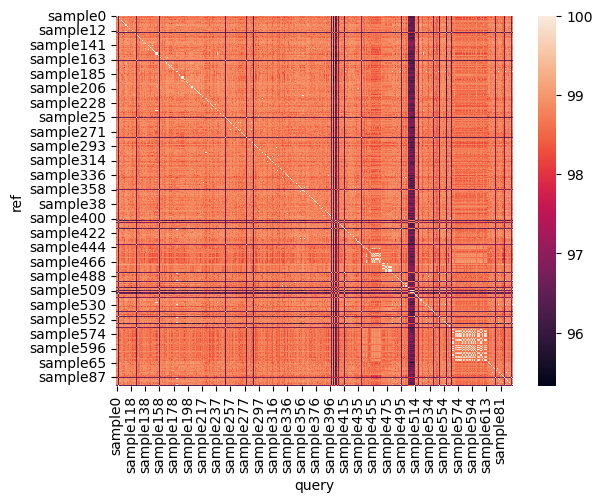

In [11]:
sns.heatmap(new_skani_matrix)

FILTER OUT HIGHLY DIVERGENT SAMPLES

In [12]:
less_than_97_dict = {}

for sample in new_skani_matrix.index:
    less_than_97 = new_skani_matrix.columns[new_skani_matrix.loc[sample] < 97].tolist()
    less_than_97_dict[sample] = less_than_97

for sample, low_similarity_samples in less_than_97_dict.items():
    print(f"{sample}: {low_similarity_samples}")

sample0: ['sample100', 'sample122', 'sample126', 'sample149', 'sample158', 'sample164', 'sample25', 'sample28', 'sample29', 'sample358', 'sample398', 'sample40', 'sample403', 'sample404', 'sample407', 'sample415', 'sample416', 'sample44', 'sample482', 'sample496', 'sample504', 'sample506', 'sample508', 'sample509', 'sample510', 'sample511', 'sample512', 'sample513', 'sample519', 'sample54', 'sample548', 'sample558', 'sample559', 'sample564', 'sample565', 'sample74', 'sample87', 'sample88', 'sample97', 'sample99']
sample1: ['sample100', 'sample122', 'sample126', 'sample149', 'sample158', 'sample164', 'sample25', 'sample28', 'sample29', 'sample358', 'sample398', 'sample40', 'sample403', 'sample404', 'sample407', 'sample415', 'sample416', 'sample44', 'sample482', 'sample496', 'sample504', 'sample506', 'sample508', 'sample509', 'sample510', 'sample511', 'sample512', 'sample513', 'sample519', 'sample54', 'sample548', 'sample558', 'sample559', 'sample565', 'sample88', 'sample99']
sample10: [

In [13]:
dissimilarity_matrix = 100 - new_skani_matrix

if (dissimilarity_matrix < 0).any().any():
    raise ValueError("skANI distance matrix contains negative values")

In [14]:
# Z = linkage(dissimilarity_matrix, method='average')

# def cluster_heatmaps(df, Z, num_clusters):
#     clusters = fcluster(Z, t=num_clusters, criterion='distance')
    
#     df['cluster'] = clusters
    
#     for cluster_num in range(1, num_clusters + 1):
#         cluster_samples = df.index[df['cluster'] == cluster_num]
        
#         submatrix = df.loc[cluster_samples, cluster_samples]
        
#         print(len(df['cluster'].unique()))
#         print(submatrix.min())

#         plt.figure(figsize=(6, 5))
#         sns.heatmap(submatrix, cbar=True)
#         plt.title(f"Heatmap for Cluster {cluster_num}")
#         plt.show()

# num_clusters = 3

# cluster_heatmaps(new_skani_matrix, Z, num_clusters)

In [47]:
def cluster_heatmaps(df, max_dist, linkage):
    clustering = AgglomerativeClustering(
        metric='precomputed', # will not recalculate distances
        linkage=linkage, # interested to see other linkages
        distance_threshold=max_dist,
        n_clusters=None
    )
    
    clusters = clustering.fit_predict(df) # assigns samples to clusters

    unique_clusters = np.unique(clusters)
    print(f"{linkage} linkage # clusters: {len(unique_clusters)}")

    cluster_divergence_list = []

    for cluster_num in unique_clusters:
        cluster_samples = np.where(clusters == cluster_num)[0]
        submatrix = df.iloc[cluster_samples, cluster_samples]
        
        max_divergence = submatrix.max().max()
        # print(f"cluster {cluster_num} max divergence: {max_divergence}")
        
        cluster_divergence_list.append({'cluster': cluster_num, 'max_divergence': max_divergence})
    
    divergence_df = pd.DataFrame(cluster_divergence_list)
    
    return clusters, divergence_df
        
        # plt.figure(figsize=(6, 5))
        # sns.heatmap(submatrix, cbar=True)
        # plt.title(f"Heatmap for Cluster {cluster_num + 1}")
        # plt.show()

IQTREE CLUSTERS

In [16]:
# def get_cluster_matrix(df, Z, num_clusters, cluster_num):
#     clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
#     df['cluster'] = clusters
    
#     cluster_samples = df.index[df['cluster'] == cluster_num]
#     submatrix = df.loc[cluster_samples, cluster_samples]
    
#     return submatrix

# get_cluster_matrix(new_skani_matrix, Z, 3, 2)

In [17]:
# threshold = np.percentile(new_skani_matrix.values, 97.5)
# divergent_samples = new_skani_matrix[(new_skani_matrix > threshold) | (new_skani_matrix < -threshold)].stack().reset_index()

# divergent_samples.columns = ['Row_Sample', 'Column_Sample', 'Value']

# print(divergent_samples)

In [45]:
max_dist = 1
linkages = ['single', 'average', 'complete']

In [46]:
for linkage in linkages:
    cluster_assignments, max_divergence_df = cluster_heatmaps(dissimilarity_matrix, max_dist, linkage)

    to_merge = pd.DataFrame({'index': dissimilarity_matrix.index, 'cluster': cluster_assignments})
    
    merged_matrix = pd.merge(skani_matrix, to_merge, left_on='ref', right_on='index', how='left')
    iqtree_matrix = merged_matrix[['Ref_file', 'cluster']].drop_duplicates().reset_index(drop=True)

    unique_clusters = iqtree_matrix['cluster'].unique()
    palette = sns.color_palette(None, len(unique_clusters))
    cluster_color_map = {cluster: f'rgba({color[0]*255:.2f},{color[1]*255:.2f},{color[2]*255:.2f},1.0)' for cluster, color in zip(unique_clusters, palette)}
    iqtree_matrix['colour'] = iqtree_matrix['cluster'].map(cluster_color_map)
    
    file_name = f'/Users/Annaliese/Desktop/PopGenStats_Project/data/{species}/tree/iqtree.skani.renamed.treefile.annot.ahc_{linkage}.txt'

    with open(file_name, 'w') as f:
        f.write("\n")
        f.write("        DATASET_COLORSTRIP\n\n")
        f.write("        SEPARATOR SPACE\n")
        f.write(f"        DATASET_LABEL ahc_{linkage}\n")
        f.write("        COLOR #ff0000\n\n")
        f.write("        COLOR_BRANCHES 0\n\n")
        f.write("        DATA\n\n")
        
        for _, row in iqtree_matrix.iterrows():
            genome_id = row['Ref_file']
            colour = row['colour']
            cluster = row['cluster']
            f.write(f"{genome_id} {colour} {cluster}\n")


single linkage # clusters: 47
average linkage # clusters: 238
complete linkage # clusters: 272


CLUSTERING

In [27]:
def get_clustered_matrix(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    
    a = np.array(distance_matrix)
    a = a[np.triu_indices_from(a, k=1)]
    
    try:
        clustering = cluster_function(a, metric=None, ** kwargs)
    except TypeError:
        clustering = cluster_function(a, ** kwargs)

    d = dict(zip(distance_matrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

def get_clusters_stats(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ref'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['query'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ref'] != matrix['query']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim


In [28]:
# matrices = {
#     # 'mummer': new_mummer_matrix,
#     'skani': new_skani_matrix
#     # 'parsnp': new_parsnp_matrix
# }

# d = {
#     'single_distance_1': (single, 1, 'distance', {}),
#     'complete_distance_1': (complete, 1, 'distance', {}),
#     'avg_distance_1': (average, 1, 'distance', {}),
#     'single_distance_96': (single, 96.5, 'distance', {}),
#     'avg_distance_98': (average, 98.5, 'distance', {})
#     # 'avg_distance_50': (average, 50, 'distance', {}),
#     # 'avg_distance_75': (average, 75, 'distance', {}),
#     # 'avg_distance_80': (average, 80, 'distance', {}),
#     # 'avg_distance_85': (average, 85, 'distance', {})
#     # 'linkage_complete_distance_10': (linkage, 10, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_25': (linkage, 25, 'distance', {'method': 'complete'})
# }

# allres_ncluster = []
# allres_intra = []
# allres_inter = []

# for matrix_name, matrix in matrices.items():
#     for method_name, values in d.items():
#         res = get_clustered_matrix(matrix, *values)
#         stats = get_clusters_stats(res)
#         ncluster, intra, inter = stats
        
#         ncluster = len(set(res[1].values()))
#         allres_ncluster.append({
#             'method': method_name,
#             'nclusters': ncluster,
#             'matrix': matrix_name
#         })

#         intra['method'] = method_name
#         intra['matrix'] = matrix_name
#         allres_intra.append(intra)
        
#         inter['method'] = method_name
#         inter['matrix'] = matrix_name
#         allres_inter.append(inter)

#         colors = list(sns.color_palette())
#         colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

#         sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors)
#         plt.title(method_name)
    
# allres_ncluster = pd.DataFrame(allres_ncluster)
# allres_inter = pd.concat(allres_inter)
# allres_intra = pd.concat(allres_intra)

# allres_intra['max'].max(), allres_inter['min'].min()

THRESHOLD VS # CLUSTERS

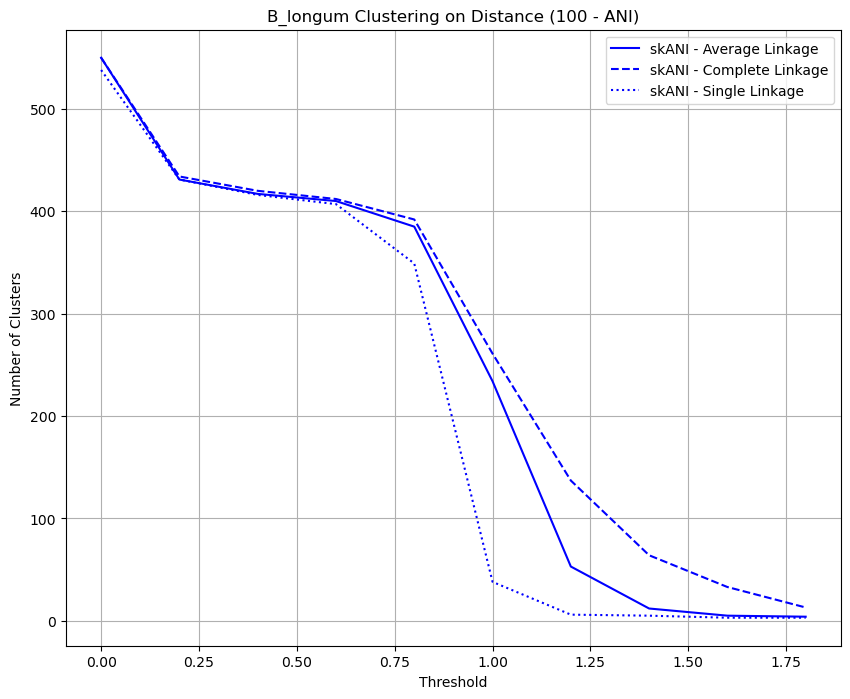

In [29]:
threshold_values = [i / 10 for i in range(0, 20, 2)]

skani_results_avg = {}
skani_results_compl = {}
skani_results_single = {}

for threshold in threshold_values:
    # average
    skani_res_a = get_clustered_matrix(dissimilarity_matrix, average, threshold, 'distance')
    skani_clusters_a = skani_res_a[1]
    num_skani_clusters_a = len(set(skani_clusters_a.values()))
    skani_results_avg[threshold] = num_skani_clusters_a

    # complete
    skani_res_c = get_clustered_matrix(dissimilarity_matrix, complete, threshold, 'distance')
    skani_clusters_c = skani_res_c[1]
    num_skani_clusters_c = len(set(skani_clusters_c.values()))
    skani_results_compl[threshold] = num_skani_clusters_c

    # single
    skani_res_s = get_clustered_matrix(dissimilarity_matrix, single, threshold, 'distance')
    skani_clusters_s = skani_res_s[1]
    num_skani_clusters_s = len(set(skani_clusters_s.values()))
    skani_results_single[threshold] = num_skani_clusters_s

plt.figure(figsize=(10, 8))

plt.plot(list(skani_results_avg.keys()), list(skani_results_avg.values()), 'b-', label='skANI - Average Linkage')
plt.plot(list(skani_results_compl.keys()), list(skani_results_compl.values()), 'b--', label='skANI - Complete Linkage')
plt.plot(list(skani_results_single.keys()), list(skani_results_single.values()), 'b:', label='skANI - Single Linkage')

plt.title(f'{species} Clustering on Distance (100 - ANI)')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [30]:
def get_y_for_x(x_value, results_dict):
    x_points = list(results_dict.keys())
    y_points = list(results_dict.values())
    
    y_interpolated = np.interp(x_value, x_points, y_points)
    return y_interpolated

x_value = 2

y_skani_avg = get_y_for_x(x_value, skani_results_avg)
y_skani_compl = get_y_for_x(x_value, skani_results_compl)
y_skani_single = get_y_for_x(x_value, skani_results_single)

print(f"Y values for x = {x_value}:")
print(f"skANI - Average Linkage: {y_skani_avg}")
print(f"skANI - Complete Linkage: {y_skani_compl}")
print(f"skANI - Single Linkage: {y_skani_single}")

Y values for x = 2:
skANI - Average Linkage: 4.0
skANI - Complete Linkage: 13.0
skANI - Single Linkage: 3.0


In [31]:
def get_clusters_for_linkage(distance_matrix, linkage_function, threshold, tool_name, linkage_name):
    res = get_clustered_matrix(distance_matrix, linkage_function, threshold, 'distance')

    clusters = res[1]

    clusters_samples_dict = defaultdict(list)
    for sample, cluster_id in clusters.items():
        clusters_samples_dict[cluster_id].append(sample)

    # print(f"\nClusters for {tool_name} with {linkage_name} linkage at threshold {threshold}:")
    for cluster_id, samples in clusters_samples_dict.items():
        # print(f"Cluster {cluster_id}:")
        # for sample in samples:
        #     print(f"  {sample}")
        samples_array = np.array(samples)
        # print(f"Cluster {cluster_id}: {samples_array}")
    return clusters_samples_dict

tools = [
    (dissimilarity_matrix, 'skANI', [average, 'Average Linkage'], [complete, 'Complete Linkage'], [single, 'Single Linkage'])
]

for distance_matrix, tool_name, *linkages in tools:
    for linkage_function, linkage_name in linkages:
        get_clusters_for_linkage(distance_matrix, linkage_function, x_value, tool_name, linkage_name)

COMPARING TOOLS

In [32]:
melted_df = pd.melt(skani_matrix, id_vars=['Tool'], value_vars=['ANI', 'aligned_bases1'], var_name='Type', value_name='Value')
melted_df

,Tool,Type,Value
0,skANI,ANI,100.000000
1,skANI,ANI,99.760000
2,skANI,ANI,98.700000
3,skANI,ANI,98.720000
4,skANI,ANI,98.850000
...,...,...,...
377605,skANI,aligned_bases1,80.857008
377606,skANI,aligned_bases1,71.102940
377607,skANI,aligned_bases1,70.375760
377608,skANI,aligned_bases1,81.648474


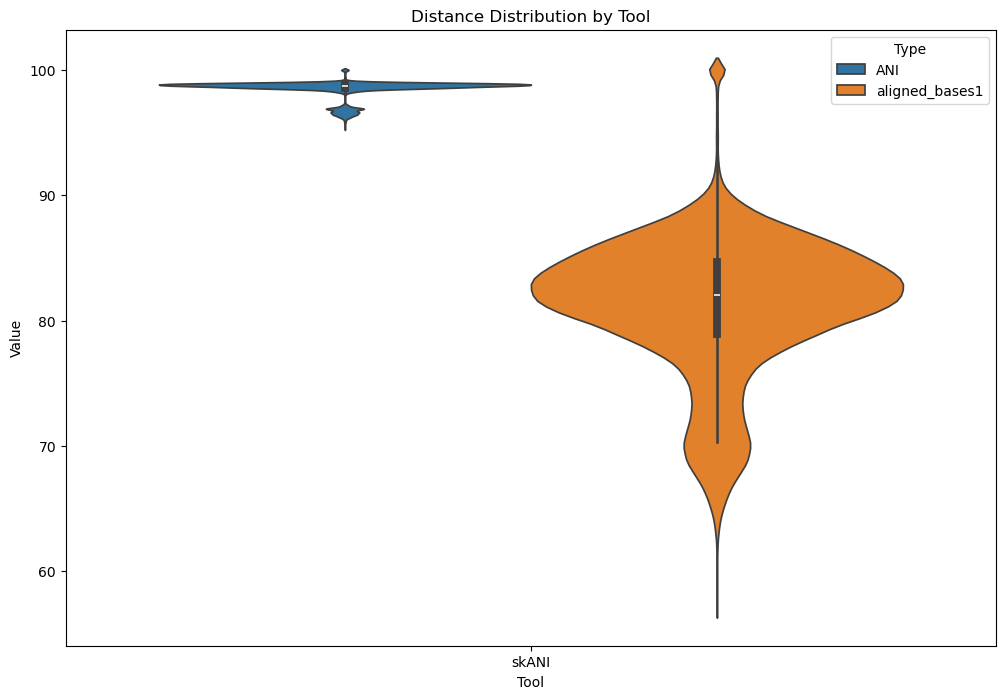

In [33]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=melted_df, x='Tool', y='Value', hue='Type')
plt.title('Distance Distribution by Tool')
plt.show()

In [34]:
filtered_melted_df = melted_df[melted_df['Type'] == 'ANI']
filtered_melted_df

,Tool,Type,Value
0,skANI,ANI,100.00
1,skANI,ANI,99.76
2,skANI,ANI,98.70
3,skANI,ANI,98.72
4,skANI,ANI,98.85
...,...,...,...
188800,skANI,ANI,98.51
188801,skANI,ANI,96.45
188802,skANI,ANI,96.67
188803,skANI,ANI,98.86


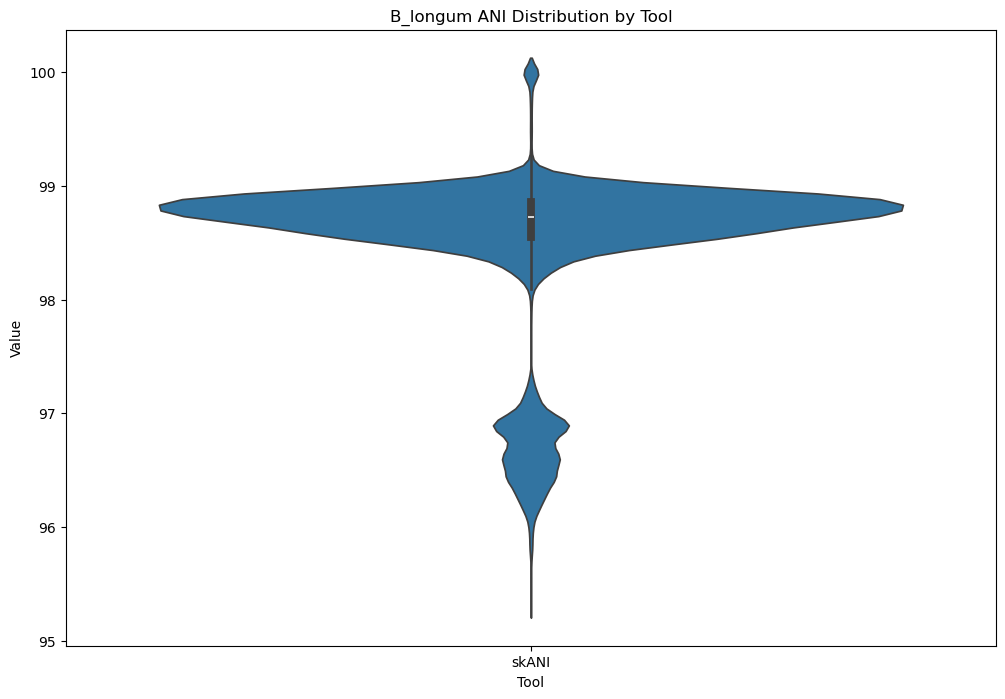

In [35]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_melted_df, x='Tool', y='Value')
plt.title(f'{species} ANI Distribution by Tool')
plt.show()

CLUSTER QUALITY CHECK

(to be updated)

In [36]:
ari_results = []

for i in range(len(tools)):
    for j in range(i + 1, len(tools)):
        tool_1 = columns[i]
        tool_2 = columns[j]
        
        ari = adjusted_rand_score(merged_df[tool_1], merged_df[tool_2])
        
        ari_results.append({'tool 1': tools[i], 'tool 2': tools[j], 'ARI': ari})

ari_df = pd.DataFrame(ari_results)
ari_df

""


In [37]:
def create_pairwise_matrix(cluster_labels):
    n = len(cluster_labels)
    pairwise_matrix = pd.DataFrame(0, index=range(n), columns=range(n))
    
    for i in range(n):
        for j in range(i, n):
            if cluster_labels[i] == cluster_labels[j]:  # Same cluster
                pairwise_matrix.at[i, j] = 1
                pairwise_matrix.at[j, i] = 1
    return pairwise_matrix

def calculate_jaccard_index(pairwise_matrix_1, pairwise_matrix_2):
    matrix_1_flat = pairwise_matrix_1.values.flatten()
    matrix_2_flat = pairwise_matrix_2.values.flatten()
    
    return jaccard_score(matrix_1_flat, matrix_2_flat)

tools = ['skder', 'cidder', 'drep', 'galah']
columns = ['nearest_representative_genome(s)_skder', 'nearest_representative_genome(s)_cidder', 
           'secondary_cluster', 'nearest_representative_genome(s)']

jaccard_results = []

pairwise_matrices = {}
for tool, column in zip(tools, columns):
    pairwise_matrices[tool] = create_pairwise_matrix(merged_df[column].values)

for tool_1, tool_2 in combinations(tools, 2):
    pairwise_matrix_1 = pairwise_matrices[tool_1]
    pairwise_matrix_2 = pairwise_matrices[tool_2]
    
    jaccard_index = calculate_jaccard_index(pairwise_matrix_1, pairwise_matrix_2)
    
    jaccard_results.append({'tool 1': tool_1, 'tool 2': tool_2, 'Jaccard Index': jaccard_index})

jaccard_df = pd.DataFrame(jaccard_results)
jaccard_df

NameError: name 'merged_df' is not defined